## Homework 5

**Submitted by : Tanvi Arora**   
**Section     : DS 7337 Natural Language Processing - 401**

<a id="top"></a>
### Contents

* <a href="#functions">Function Definitions</a>
* <a href="#moviedata">1 - Movie Data Collection</a>
* <a href="#movieselection">1.a - movie selection</a>
* <a href="#userreviewselection">1.b - User Reviews Selection for each movie</a>
* <a href="#userreviewanalysis">1.c/d - Analysis on movie and user review data collected</a>
* <a href="#userreviewdata">2 - User Review Data Collection and Analysis</a>
* <a href="#userreview">2.a Main review text from each User link</a>
* <a href="#npchunk1">2.b NP-chunk user reviews with shallow parser</a>
* <a href="#castcharacter">2.c Cast and Character list of movies selected</a>
* <a href="#summary">3 Summary of work done</a>

In [4]:
import platform
print(platform.platform())

import os
print ("environment",os.environ['CONDA_DEFAULT_ENV'])

import sys
print("Python",sys.version)

import nltk
from nltk.tokenize import regexp_tokenize
print("nltk",nltk.__version__)

#from nltk.tag.util import tuple2str

import numpy
print("numpy", numpy.__version__)

from bs4 import BeautifulSoup
import requests
#from __future__ import division, unicode_literals 
from urllib import request
from tabulate import tabulate
import pandas as pd

## for visualizations
import matplotlib.pyplot as plt

pd.set_option('display.max_rows',10)
import re
from random import randint

## spaCy library
import spacy
sp_nlp=spacy.load('en')

## ignore/suppress warnings
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)

Darwin-18.5.0-x86_64-i386-64bit
environment base
Python 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
nltk 3.4
numpy 1.16.1


### References :

https://www.dataquest.io/blog/web-scraping-beautifulsoup/
https://medium.com/@madanflies/top-50-shows-recommendation-scrap-from-imdb-using-beautiful-soup-in-python-610035ac1eb7

<a id="functions"></a>
<a href="#top">Back to Top</a>

### Function Definitions

In [42]:
## call main URL
baseurl="https://www.imdb.com"
biographylink="https://www.imdb.com/search/title/?release_date=2010-01-01,2019-12-31&genres=biography&page=1"

## returns webpage content if web page accessible else None
def getSoup(url):
    grab_page = requests.get(url,timeout=5)
    if grab_page.status_code != 200:
        print("Error:page not found")
        return None
    else:
        #print("page found")
        return BeautifulSoup(grab_page.content, 'html5lib')

## basic beautiful soup read function 
def read_html(url):
    html = request.urlopen(url).read().decode('utf8')
    raw = BeautifulSoup(html, 'html.parser').get_text()
    tokens = word_tokenize(raw)
    text = nltk.Text(tokens)
    return text

## fetch main page data
def get_movie_home_container(searchurl):
    moviehome_soup=getSoup(searchurl)
    return moviehome_soup.find_all('div', class_ = "lister-item-content")

## fetch movie list from the main page data
## currently this function gets data from default or first page from search url
## this function returns a dataframe that contains list of movie names, individual movie links
## imdb ratings ( average of user ratings), metascores and # of votes that can be use for 
## further data analysis
def get_movielist_home(homecontainer):
    names=[]
    movielinks=[]
    imdb_ratings=[]
    metascores=[]
    votes=[]
    for container in homecontainer:
    # Look for movies with a Metascore
        if container.find('div', class_='inline-block ratings-metascore') is not None:
            names.append(container.h3.a.text)
            movielinks.append(baseurl+container.h3.a.attrs["href"])
            imdb_ratings.append(float(container.strong.text))
            metascores.append(float(container.find('span',class_='metascore').text))
            votes.append(container.find('span',attrs = {'name':'nv'})['data-value'])
        
        m_df=pd.DataFrame({'moviename':names,
                      'movielinks':movielinks,
                      'imdb_ratings':imdb_ratings,
                      'metascores':metascores,
                      'votes':votes})
    return m_df

## This function returns the main user review page from the individual movie link
def get_movie_user_review_link(movie_url):
    imovie_containers=[]
    imovie_soup=getSoup(movie_url)
    imovie_userreview_container = imovie_soup.find_all('div', class_ = "user-comments")
    #print(type(imovie_userreview_container))
    #print(len(imovie_userreview_container))
    return [baseurl+alink.attrs["href"] for alink in imovie_userreview_container[0].find_all('a') if re.findall(r"user reviews$",alink.text)]

## This function gets the cast and character list that can be further used to 
## build a custom lexicon for Proper Nouns
def get_movie_cast_charc_list(movie_url):
    imovie_soup=getSoup(movie_url)
    imovie_cast_container=imovie_soup.find_all('table', class_ = "cast_list")
    cast_list=[re.sub('\s+',' ',(cast.find('a').text).strip(' \n\t')) for cast in imovie_cast_container[0].find_all('td', class_=None)]
    character_list=[re.sub('\s+',' ',(cast.text).strip(' \n\t')) for cast in imovie_cast_container[0].find_all('td', class_="character")]
    return (cast_list,character_list)


## This function generates a list of 6 random numbers, 
## 3 in the range of 1 to 5 and 3 in the range of 6-10
def get_random_number_list(total,lownum,highnum):
    setOfNumbers = set()
    while len(setOfNumbers) < total/2:
        setOfNumbers.add(randint(lownum, round(highnum/2,0)))
    
    while len(setOfNumbers) < total:
        setOfNumbers.add(randint(round(highnum/2,0) , highnum))
                         
    return setOfNumbers
    
## This function returns a dataframe of individual user review links(permalink) and some
## additional information for each user review like review_date, user_rating , 
## user rating pointscale and user review title
## It also accepts number of reviews required per movie as input
def get_movie_user_reviews(movie_df,num_reviews_):
    m_ind=0
    num_reviews=num_reviews_
    movie_index=[]
    review_date=[]
    user_rating=[]
    user_pointscale=[]
    permalink=[]
    title=[]

    for m in movie_df["user_review_link"]:
        #print("review page :", m)
        m_ind=m_ind+1
        #print("movie# :", m_ind-1)
        n=0
        user_review_soup=getSoup(m[0])
        imovie_user_review_container=user_review_soup.find_all('div', class_="lister-item mode-detail imdb-user-review collapsable")
        #reviewpoints=[randint(1, 10) for i in range(0,num_reviews)]
        reviewpoints=get_random_number_list(num_reviews,1,10)
        #print(reviewpoints)
        for ur in imovie_user_review_container:
            #print(ur.find('a', class_='title').text)
            rating=[int(rating.text) for rating in ur.find_all('span', class_=None) if (rating.text.isnumeric() and rating.text is not None)]
            #print("rating: ",rating)
            if len(rating)!=0:
                if rating[0] in reviewpoints:

                    movie_index.append(m_ind-1)
                    user_rating.append(rating[0])
                    review_date.append(ur.find('span',class_="review-date").text)
                    user_pointscale.append(ur.find_all('span', class_='point-scale')[0].text)
                    #user_review.append(ur.find('div', class_=re.compile(r"show-more")).text)
                    permalink.append([ baseurl+link.attrs["href"] for link in ur.find_all('a') if link.text=="Permalink"][0])
                    title.append(ur.find('a', class_='title').text)
                    #print(ur.find('a', class_='title').text)
                    #print(ur.find('div', class_=re.compile(r"show-more")).text)
                    n=n+1
                    #print("====================")
                if n==num_reviews:
                    break
    


    user_review_df=pd.DataFrame({"movie#":movie_index,
                                "user_rating":user_rating,
                                "rating_point_scale":user_pointscale,
                                "review_date":review_date,
                                "permalink":permalink,
                                "title":title})
    return user_review_df

## based on user rating this function returns if review is positive(>=5) or negative(<5)
def get_user_rating_label(rating):
    if rating>=5:
        return "positive"
    else:
        return "negative"

## this function returns actual user review text and title from the individual user review link(permalink)
def get_user_review(user_review_url):
    imovie_name=[]
    ireview_title=[]
    iuser_review=[]
    ireview_soup=getSoup(user_review_url)
    ireview_container=ireview_soup.find_all('div', class_="lister-item-content")
    for review in ireview_container:
        imovie_name=review.find_all('div', class_="lister-item-header")[0].find_all('a')[0].text
        ireview_title=review.find('a', class_="title").text
        iuser_review=review.find('div', class_=re.compile(r"show-more")).text
    return imovie_name,ireview_title,iuser_review

## this function calls get_user_review function for the list of user_review links
def get_all_user_review(review_df):
    movie_name=[]
    review_title=[]
    user_review=[]
    for link in review_df["permalink"]:
        mname,rtitle,ureview=get_user_review(link)
        movie_name.append(mname)
        review_title.append(rtitle)
        user_review.append(ureview)
    return movie_name,review_title,user_review

## this function returns NP using spaCy library
def get_np_chunks(sentence):
    doc=sp_nlp(sentence)
    return [np.text for np in doc.noun_chunks]        

<a id="moviedata"></a>
<a href="#top">Back to Top</a>
### Movie Data Collection

**website** www.imdb.com  
**Genre** Biography

<a id="movieselection"></a>
<a href="#top">Back to Top</a>

### Movie Selection

In [6]:
## Call Main

moviehome_container=get_movie_home_container(biographylink)
print(type(moviehome_container))
print(len(moviehome_container))
movie_df=get_movielist_home(moviehome_container)

<class 'bs4.element.ResultSet'>
50


In [7]:
movie_df

,moviename,movielinks,imdb_ratings,metascores,votes
0,Rocketman,https://www.imdb.com/title/tt2066051/,7.7,69.0,37536
1,Bohemian Rhapsody,https://www.imdb.com/title/tt1727824/,8.0,49.0,352216
2,"Extremely Wicked, Shockingly Evil and Vile",https://www.imdb.com/title/tt2481498/,6.7,52.0,42354
3,Green Book,https://www.imdb.com/title/tt6966692/,8.2,69.0,212914
4,Fighting with My Family,https://www.imdb.com/title/tt6513120/,7.2,68.0,30838
...,...,...,...,...,...
33,The Intouchables,https://www.imdb.com/title/tt1675434/,8.5,57.0,679839
34,The Front Runner,https://www.imdb.com/title/tt7074886/,6.2,61.0,6723
35,The Current War,https://www.imdb.com/title/tt2140507/,5.9,42.0,651
36,Molly's Game,https://www.imdb.com/title/tt4209788/,7.5,71.0,105761


In [8]:
## Get user review page for each movie
movie_df["user_review_link"]=movie_df.apply(lambda row : get_movie_user_review_link(row["movielinks"]), axis=1)
movie_df

,moviename,movielinks,imdb_ratings,metascores,votes,user_review_link
0,Rocketman,https://www.imdb.com/title/tt2066051/,7.7,69.0,37536,[https://www.imdb.com/title/tt2066051/reviews]
1,Bohemian Rhapsody,https://www.imdb.com/title/tt1727824/,8.0,49.0,352216,[https://www.imdb.com/title/tt1727824/reviews]
2,"Extremely Wicked, Shockingly Evil and Vile",https://www.imdb.com/title/tt2481498/,6.7,52.0,42354,[https://www.imdb.com/title/tt2481498/reviews]
3,Green Book,https://www.imdb.com/title/tt6966692/,8.2,69.0,212914,[https://www.imdb.com/title/tt6966692/reviews]
4,Fighting with My Family,https://www.imdb.com/title/tt6513120/,7.2,68.0,30838,[https://www.imdb.com/title/tt6513120/reviews]
...,...,...,...,...,...,...
33,The Intouchables,https://www.imdb.com/title/tt1675434/,8.5,57.0,679839,[https://www.imdb.com/title/tt1675434/reviews]
34,The Front Runner,https://www.imdb.com/title/tt7074886/,6.2,61.0,6723,[https://www.imdb.com/title/tt7074886/reviews]
35,The Current War,https://www.imdb.com/title/tt2140507/,5.9,42.0,651,[https://www.imdb.com/title/tt2140507/reviews]
36,Molly's Game,https://www.imdb.com/title/tt4209788/,7.5,71.0,105761,[https://www.imdb.com/title/tt4209788/reviews]


<a id="userreviewselection"></a>
<a href="#top">Back to Top</a>

### User Reviews Selection for each movie

In [9]:
# get 5 random user reviews for each movie
user_review_df=get_movie_user_reviews(movie_df,6)
print(len(user_review_df))
print(user_review_df.head())

216
   movie#  user_rating rating_point_scale  review_date  \
0       0            8                /10  1 June 2019   
1       0            7                /10  19 May 2019   
2       0            7                /10  31 May 2019   
3       0            8                /10  23 May 2019   
4       0            7                /10  20 May 2019   

                                permalink  \
0  https://www.imdb.com/review/rw4904840/   
1  https://www.imdb.com/review/rw4865567/   
2  https://www.imdb.com/review/rw4901956/   
3  https://www.imdb.com/review/rw4882554/   
4  https://www.imdb.com/review/rw4868061/   

                                           title  
0   Give Taron Egerton an Oscar IMMEDIATELY!!!\n  
1                   Should have expected this.\n  
2                      A musical as pop as sad\n  
3                       Taron Egerton is fab!!\n  
4                Rocketman > Bohemian Rhapsody\n  


In [47]:

user_review_df["user_review_label"]=user_review_df["user_rating"].apply(get_user_rating_label)
user_review_df[["user_rating","user_review_label"]].head(7)

,user_rating,user_review_label
0,8,positive
1,7,positive
2,7,positive
3,8,positive
4,7,positive
5,3,negative
6,9,positive


<a id="userreviewanalysis"></a>
<a href="#top">Back to Top</a>

### Analysis on movie and user review data collected

In [53]:
## how many positive and negative reviews have we collected 
user_review_df[["user_review_label","movie#"]].groupby(by="user_review_label").count()

,movie#
user_review_label,
negative,30
positive,186


<span style="color:blue">A little skewed data here we have a lot more positive reviews than negative. There is scope of improvement here by extending the movie reviews to more than the default pages.</span>

In [40]:
user_review_df[["user_rating","movie#"]].groupby(by="movie#").count()

,user_rating
movie#,
0,6
1,6
2,6
3,6
4,6
...,...
33,6
34,6
35,5


In [39]:
user_review_df[["user_rating","movie#"]].groupby(by="user_rating").count()

,movie#
user_rating,
1,9
2,11
3,4
4,6
5,18
6,14
7,26
8,44
9,42


<span style="color:blue">We have user ratings from all the movies we have selected ( 38 movies ) and while the intention was to get max of 6 user reviews, for few movies there are less than 6 reviews. Review ratings range from 1 to 10 as expected.While a little more non-skewed data is expected, it is better to no go over-board with getting equal number of positive and negative reviews. Data collected is limited and as per the data selected, this kind of skewness can be expected.</span>

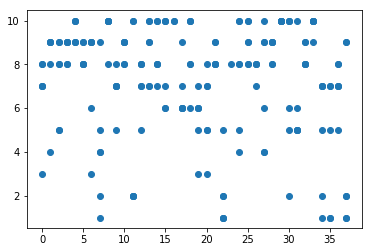

In [12]:
plt.scatter(user_review_df["movie#"],user_review_df["user_rating"])

<span style="color:blue">looks like we have good amount of reviews with user-ratings in the range of 1 to 10</span>

#### Why do some movies have only high reviews when we randomly selected ratings b/w 1-10 ?

In [13]:
user_review_df[user_review_df["movie#"]==4]

,movie#,user_rating,rating_point_scale,review_date,permalink,title
24,4,9,/10,17 February 2019,https://www.imdb.com/review/rw4665912/,Heartwarming movie based on a true story\n
25,4,10,/10,18 February 2019,https://www.imdb.com/review/rw4672003/,Funny! Entertaining!\n
26,4,9,/10,24 February 2019,https://www.imdb.com/review/rw4683116/,Comedic heartwarming film even for non-wrestl...
27,4,10,/10,30 January 2019,https://www.imdb.com/review/rw4616887/,Loved it\n
28,4,10,/10,24 February 2019,https://www.imdb.com/review/rw4682911/,Best wrestling movie since ready to rumble\n
29,4,9,/10,22 February 2019,https://www.imdb.com/review/rw4679947/,MoreThan Nostalgia\n


In [14]:
movie_df["user_review_link"][4][0]

'https://www.imdb.com/title/tt6513120/reviews'

<span style="color:blue">Reviews are based on the first page of the user review link. Although random ratings in the range of 1-10 were selected, having equal number in the lower and higher range, the page( in the above chosen sample) has no reviews in lower range.With the expectation of  gathering mixed bag of user reviews , realistic approach could be there is collection of actual good movies too.</span>

<a id="userreviewdata"></a>
<a href="#top">Back to Top</a>
### User review Data Collection and Analysis

<a id="userreview"></a>
<a href="#top">Back to Top</a>


### Main review text from each User link

In [15]:
usermovie,usertitle,userreview=get_all_user_review(user_review_df)

In [16]:
print(len(usermovie))
print(len(usertitle))
print(len(userreview))

216
216
216


<span style="color:blue">Total number of user reviews collected are 216</span>

In [44]:
user_review_df["user_movie_name"]=usermovie
user_review_df["user_review_title"]=usertitle
user_review_df["user_review"]=userreview
user_review_df[["user_movie_name","user_review_title","user_review"]].head()

,user_movie_name,user_review_title,user_review
0,Rocketman,Give Taron Egerton an Oscar IMMEDIATELY!!!\n,He was AMAZING in the spirit of an fabulous El...
1,Rocketman,Should have expected this.\n,It's going to get very mixed reviews. I predic...
2,Rocketman,A musical as pop as sad\n,"First things first, Elton John being one of th..."
3,Rocketman,Taron Egerton is fab!!\n,"Really good biopic, different to what I though..."
4,Rocketman,Rocketman > Bohemian Rhapsody\n,Rocketman decides to focus on Elton John's cha...


<a id="npchunk1"></a>
<a href="#top">Back to Top</a>


### NP-chunk user reviews with shallow parser

In [18]:
user_review_df["user_review_np_chunks"]=user_review_df["user_review"].apply(get_np_chunks)

In [19]:
user_review_df.head()

,movie#,user_rating,rating_point_scale,review_date,permalink,title,user_movie_name,user_review_title,user_review,user_review_np_chunks
0,0,8,/10,1 June 2019,https://www.imdb.com/review/rw4904840/,Give Taron Egerton an Oscar IMMEDIATELY!!!\n,Rocketman,Give Taron Egerton an Oscar IMMEDIATELY!!!\n,He was AMAZING in the spirit of an fabulous El...,"[He, the spirit, an fabulous Elton John, Jamie..."
1,0,7,/10,19 May 2019,https://www.imdb.com/review/rw4865567/,Should have expected this.\n,Rocketman,Should have expected this.\n,It's going to get very mixed reviews. I predic...,"[It, very mixed reviews, I, it, it, I, the mid..."
2,0,7,/10,31 May 2019,https://www.imdb.com/review/rw4901956/,A musical as pop as sad\n,Rocketman,A musical as pop as sad\n,"First things first, Elton John being one of th...","[First things, Elton John, the most famous art..."
3,0,8,/10,23 May 2019,https://www.imdb.com/review/rw4882554/,Taron Egerton is fab!!\n,Rocketman,Taron Egerton is fab!!\n,"Really good biopic, different to what I though...","[Really good biopic, what, I, it, Taron Egerto..."
4,0,7,/10,20 May 2019,https://www.imdb.com/review/rw4868061/,Rocketman > Bohemian Rhapsody\n,Rocketman,Rocketman > Bohemian Rhapsody\n,Rocketman decides to focus on Elton John's cha...,"[Rocketman, Elton John's character evolution, ..."


In [ ]:
user_review_df.to_csv('user_review.csv',sep=",")


In [ ]:
#### Build working lexicon that includes cast and character list

<a id="castcharacter"></a>
<a href="#top">Back to Top</a>


### Get cast and character list of movies to build a movie lexicon

In [22]:
mlist=movie_df.apply(lambda row : get_movie_cast_charc_list(row["movielinks"]), axis=1)
mlist

0     ([Taron Egerton, Jamie Bell, Richard Madden, B...
1     ([Rami Malek, Lucy Boynton, Gwilym Lee, Ben Ha...
2     ([Lily Collins, Zac Efron, Angela Sarafyan, Sy...
3     ([Viggo Mortensen, Mahershala Ali, Linda Carde...
4     ([Dwayne Johnson, Thomas Whilley, Tori Ellen R...
                            ...                        
33    ([François Cluzet, Omar Sy, Anne Le Ny, Audrey...
34    ([Hugh Jackman, Vera Farmiga, J.K. Simmons, Ma...
35    ([Tom Holland, Benedict Cumberbatch, Nicholas ...
36    ([Jessica Chastain, Idris Elba, Kevin Costner,...
37    ([Jesse Eisenberg, Rooney Mara, Bryan Barter, ...
Length: 38, dtype: object

In [24]:
cast_list=[]
character_list=[]
for m in mlist:
    cast_list.append(m[0])
    character_list.append(m[1])
movie_df["cast_list"]=cast_list
movie_df["character_list"]=character_list
movie_df.head()

,moviename,movielinks,imdb_ratings,metascores,votes,user_review_link,cast_list,character_list
0,Rocketman,https://www.imdb.com/title/tt2066051/,7.7,69.0,37536,[https://www.imdb.com/title/tt2066051/reviews],"[Taron Egerton, Jamie Bell, Richard Madden, Br...","[Elton John, Bernie Taupin, John Reid, Sheila,..."
1,Bohemian Rhapsody,https://www.imdb.com/title/tt1727824/,8.0,49.0,352216,[https://www.imdb.com/title/tt1727824/reviews],"[Rami Malek, Lucy Boynton, Gwilym Lee, Ben Har...","[Freddie Mercury, Mary Austin, Brian May, Roge..."
2,"Extremely Wicked, Shockingly Evil and Vile",https://www.imdb.com/title/tt2481498/,6.7,52.0,42354,[https://www.imdb.com/title/tt2481498/reviews],"[Lily Collins, Zac Efron, Angela Sarafyan, Syd...","[Liz Kendall, Ted Bundy, Joanna, Babysitter, 2..."
3,Green Book,https://www.imdb.com/title/tt6966692/,8.2,69.0,212914,[https://www.imdb.com/title/tt6966692/reviews],"[Viggo Mortensen, Mahershala Ali, Linda Cardel...","[Tony Lip, Dr. Donald Shirley, Dolores, Johnny..."
4,Fighting with My Family,https://www.imdb.com/title/tt6513120/,7.2,68.0,30838,[https://www.imdb.com/title/tt6513120/reviews],"[Dwayne Johnson, Thomas Whilley, Tori Ellen Ro...",[Dwayne 'The Rock' Johnson (as Dwayne 'The Roc...


In [49]:
movie_df[["moviename","cast_list","character_list"]].head(7)

,moviename,cast_list,character_list
0,Rocketman,"[Taron Egerton, Jamie Bell, Richard Madden, Br...","[Elton John, Bernie Taupin, John Reid, Sheila,..."
1,Bohemian Rhapsody,"[Rami Malek, Lucy Boynton, Gwilym Lee, Ben Har...","[Freddie Mercury, Mary Austin, Brian May, Roge..."
2,"Extremely Wicked, Shockingly Evil and Vile","[Lily Collins, Zac Efron, Angela Sarafyan, Syd...","[Liz Kendall, Ted Bundy, Joanna, Babysitter, 2..."
3,Green Book,"[Viggo Mortensen, Mahershala Ali, Linda Cardel...","[Tony Lip, Dr. Donald Shirley, Dolores, Johnny..."
4,Fighting with My Family,"[Dwayne Johnson, Thomas Whilley, Tori Ellen Ro...",[Dwayne 'The Rock' Johnson (as Dwayne 'The Roc...
5,The Professor and the Madman,"[Natalie Dormer, Mel Gibson, Sean Penn, Jennif...","[Eliza Merrett, James Murray, Dr. William Ches..."
6,Vice,"[Christian Bale, Amy Adams, Steve Carell, Sam ...","[Dick Cheney, Lynne Cheney, Donald Rumsfeld, G..."


<a id="summary"></a>
<a href="#top">Back to Top</a>
### Summary of work

I have selected www.imdb.com to get user reviews and ratings .

#### Why IMDB ?

**IMDB(Internet Movie Database)**  is an online database of information related to films, television programs, home videos and video games, straming content online -- including cast, production crew and personnel biographies, plot summaries, trivia and dan reviews and ratings. is the world's most popular and authoritative source for movie, TV and celebrity content.It has ratings and reviews for the newest movies and TV shows as well.

**Features**
1. Movie and talent pages are accessible to all internet users. Data published is screened before publication. So it is a reliable source of data
2. Data is crawlable 

#### Data Selection Criteria

**Genre** Biography  
**Year**  2010-2019  

**Any filters** 
1. Movies with a Metascore 
_Metascore is the score of the movie on the metacritic website.It assigns scores almost in the same range as rotten tomatoes most of the time. Scores are given by movie critics and the weighted score ( based on the fame if the critic ) is finally assigned. usually, "very good"(critical favorites) movies have score above 70_
2. Movies from 1st or default page ( Top 50 movies based on Helpfulness)


#### Source of reviews
1. For each movie in the list, movie url page is collected
2. From the movie url, user reviews high level detail is collected

**Selection criteria for user reviews**
1. User reviews with a rating ( filtered movies with spoiler alerts )
2. A list of 6 random numbers , 3 in the range of 1 to 5 and 3 in the range of 6 to 10 is randomly generated for each movie, call it random_rating_score. Max of 6 user reviews from the first/default page and having rating as one of the random_rating_score are selected to get a mixed bag of user reviews. Since only first  page is considered, for some movies less than 6 reciews were collected.

**Data Collected**
1. For user reviews, review_date , title, rating by the user, rating point scale and user review link is collected
2. From each user review link, user review text, Title is collected



#### How many collected and by what means

1. **# of movies collected based on above criteria :** 38
2. **# of user reviews collected for each movie :** 6
3. **# of reviews in total :** 216

#### What is missing or scope of improvement :

1. browse through multiple pages of movie list and user review list
2. consider movies with no ratings ( analyze the data for them and if required put null values )
3. Build a custom lexicon to add proper nouns from movie character and cast names




### NP Chunks of user reviews collected

In [63]:
pd.set_option('display.max_rows',250)
user_review_df[["user_movie_name","user_rating","user_review_label","user_review_np_chunks"]]

,user_movie_name,user_rating,user_review_label,user_review_np_chunks
0,Rocketman,8,positive,"[He, the spirit, an fabulous Elton John, Jamie..."
1,Rocketman,7,positive,"[It, very mixed reviews, I, it, it, I, the mid..."
2,Rocketman,7,positive,"[First things, Elton John, the most famous art..."
3,Rocketman,8,positive,"[Really good biopic, what, I, it, Taron Egerto..."
4,Rocketman,7,positive,"[Rocketman, Elton John's character evolution, ..."
5,Rocketman,3,negative,"[Bravo, the great singing, Taron Egerton, the ..."
6,Bohemian Rhapsody,9,positive,"[My wife, I, We, Queen fans, the tribute conce..."
7,Bohemian Rhapsody,8,positive,"[I, the world, oh boy, me, you, it, This movie..."
8,Bohemian Rhapsody,9,positive,"[This movie, a brilliant portrayal, the mixed ..."
9,Bohemian Rhapsody,9,positive,"[the best movies, the year, The performances, ..."


In [91]:
user_review_df[["user_movie_name","user_rating","user_review_np_chunks"]].to_csv("user_review_np_chunks.csv",sep=",")